# K-Means Land Classification with Dask

K-Means is a clustering algorithm that creates a segmentation map of different "clusters" which can represent estimated/easily-separable classifications which share similar values to a centroid optimum that represents the groups mean value. The classifications should not be considered accurate and requires verification - however it is a great starting point for unsupervised classification problems to determine separable classes. 

For geospatial applications, we can use K-Means to create rough land-classification segmentation maps or generate automated labeled data given supporting methods to verify the classification is correct. 

In [3]:
# We will be using Sentinel-2 L2A imagery from Microsoft Planetary Computer STAC server:
!pip install planetary_computer

In [4]:
import os
import rasterio
import rioxarray
import pystac
import stackstac
import datetime
import planetary_computer
import dask
import json
import gcsfs

import dask_ml.cluster

import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd

from skimage.exposure import rescale_intensity
from dask_gateway import Gateway
from shapely.geometry import Polygon
from pystac_client import Client

## 1. Initialize Dask Cluster

We will use Dask to power our computations of a K-Means algorithm with which will be fitted and used to for predictions.
Start by initializing a dask cluster in a separate notebook and connecting to it. This notebook was tested using 3 cores with 12 gb of RAM. We then scaled our cluster to have 5 workers.

Remember to replace the dask cluster's name below with the one you instantiate.

In [5]:
gateway = Gateway()
cluster = gateway.connect('daskhub.f3bf0be2d99540289953f8341e122568')
client = cluster.get_client()
cluster

AttributeError: 'VBox' object has no attribute '_ipython_display_'

GatewayCluster<daskhub.f3bf0be2d99540289953f8341e122568, status=running>

## AOI

This AOI was generated from: https://www.keene.edu/campus/maps/tool/ 

We will, for the purpose of this demonstration, look at the Timberlea suburb in Montreal, Quebec, Canada

In [6]:
polygon = {
  "coordinates": [
    [
      [
        -73.8847303,
        45.4294192
      ],
      [
        -73.883357,
        45.4445361
      ],
      [
        -73.9108229,
        45.4442049
      ],
      [
        -73.9120245,
        45.4263471
      ],
      [
        -73.8847303,
        45.4294192
      ]
    ]
  ],
  "type": "Polygon"
}
polygon

{'coordinates': [[[-73.8847303, 45.4294192],
   [-73.883357, 45.4445361],
   [-73.9108229, 45.4442049],
   [-73.9120245, 45.4263471],
   [-73.8847303, 45.4294192]]],
 'type': 'Polygon'}

In [7]:
lon_list = []
lat_list = []

for lon,lat in polygon['coordinates'][0]:
    lon_list.append(lon)
    lat_list.append(lat)
polygon_geom = Polygon(zip(lon_list, lat_list))
crs = 'EPSG:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])
polygon

,geometry
0,"POLYGON ((-73.88473 45.42942, -73.88336 45.444..."


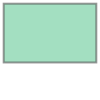

In [8]:
FOOTPRINT = polygon.to_crs('epsg:4326').geometry[0].envelope
FOOTPRINT

In [9]:
# Set up Stac Client
api = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
api

ID: microsoft-pc
Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer
type: Catalog
"conformsTo: ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30', 'http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/filter', 'https://api.stacspec.org/v1.0.0-rc.1/collections', 'https://api.stacspec.org/v1.0.0-rc.1/core', 'https://api.stacspec.org/v1.0.0-rc.1/item-search', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#fields', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:basic-cql', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-json', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-text', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#query', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#sort', 'https://api.stacspec.org/v1.0.0-rc.1/ogcapi-features']"
ID: daymet-annual-pr
Title: Daymet Annual Puerto Rico
"Description: Annual climate summaries derived from [Daymet](https://daymet.ornl.gov) Version 4 daily data at a 1 km x 1 km spatial resolution for five variables: minimum and maximum temperature, precipitation, vapor pressure, and snow water equivalent. Annual averages are provided for minimum and maximum temperature, vapor pressure, and snow water equivalent, and annual totals are provided for the precipitation variable. [Daymet](https://daymet.ornl.gov/) provides measurements of near-surface meteorological conditions; the main purpose is to provide data estimates where no instrumentation exists. The dataset covers the period from January 1, 1980 to the present. Each year is processed individually at the close of a calendar year. Data are in a Lambert conformal conic projection for North America and are distributed in Zarr and NetCDF formats, compliant with the [Climate and Forecast (CF) metadata conventions (version 1.6)](http://cfconventions.org/). Use the DOI at [https://doi.org/10.3334/ORNLDAAC/1852](https://doi.org/10.3334/ORNLDAAC/1852) to cite your usage of the data. This dataset provides coverage for Hawaii; North America and Puerto Rico are provided in [separate datasets](https://planetarycomputer.microsoft.com/dataset/group/daymet#annual)."
"Providers: Microsoft (host, processor) ORNL DAAC (producer)"
type: Collection
title: Daymet Annual Puerto Rico


In [10]:
# CONFIG 
# -------------
TGT_BANDS =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A']
YEAR = '2021'
BEGIN_MONTH = '07'
END_MONTH = '08'
DATE_RANGE = f'{YEAR}-{BEGIN_MONTH}-01/{YEAR}-{END_MONTH}-30'
MAX_CLOUD = 5
READ_IN_CHUNK = 4096
RESOLUTION = 10
# -------------

In [11]:
# In our AOI with a max cloud cover of 5%, we find one image
items = api.search(
        collections = ['sentinel-2-l2a'],
        intersects = FOOTPRINT,
        query={"eo:cloud_cover": {"lt": MAX_CLOUD}},
        datetime = DATE_RANGE,
    ).get_all_items()
    
print(f'\tFound {len(items)} items')

	Found 1 items


In [12]:
# Planetary Computer requires signing the items HREF so we can pull the Asset
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [13]:
# Create an Xarray DataArray of the pystac_client query results
data = (
    stackstac.stack(
        signed_items,
        assets=TGT_BANDS, 
        chunksize=READ_IN_CHUNK, # Set chunksize
        resolution=RESOLUTION, # Set all bands res to this
        bounds_latlon=FOOTPRINT.bounds, # clip to AOI bounds
    ).where(lambda x: x > 0, other=np.nan) # Convert nodata zero to np.nan
)
data

<xarray.DataArray 'stackstac-18168091714cd7d2fc565c6e96eb1fae' (time: 1,
                                                                band: 12,
                                                                y: 207, x: 228)>
dask.array<where, shape=(1, 12, 207, 228), dtype=float64, chunksize=(1, 1, 207, 228), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2021-08-03...
    id                                       (time) <U54 'S2A_MSIL2A_20210803...
  * band                                     (band) <U3 'B01' 'B02' ... 'B8A'
  * x                                        (x) float64 5.851e+05 ... 5.874e+05
  * y                                        (y) float64 5.033e+06 ... 5.031e+06
    sat:relative_orbit                       int64 54
    ...                                       ...
    title                                    (band) <U37 'Band 1 - Coastal ae...
    gsd                                      (band) float64 60.0 10.0 ... 20.0
    common_name                              (band) object 'coastal' ... 'red...
    center_wavelength                        (band) float64 0.443 0.49 ... 0.865
    full_width_half_max                      (band) float64 0.027 ... 0.033
    epsg                                     int64 32618
Attributes:
    spec:        RasterSpec(epsg=32618, bounds=(585080, 5030880, 587360, 5032...
    crs:         epsg:32618
    transform:   | 10.00, 0.00, 585080.00|\n| 0.00,-10.00, 5032950.00|\n| 0.0...
    resolution:  10

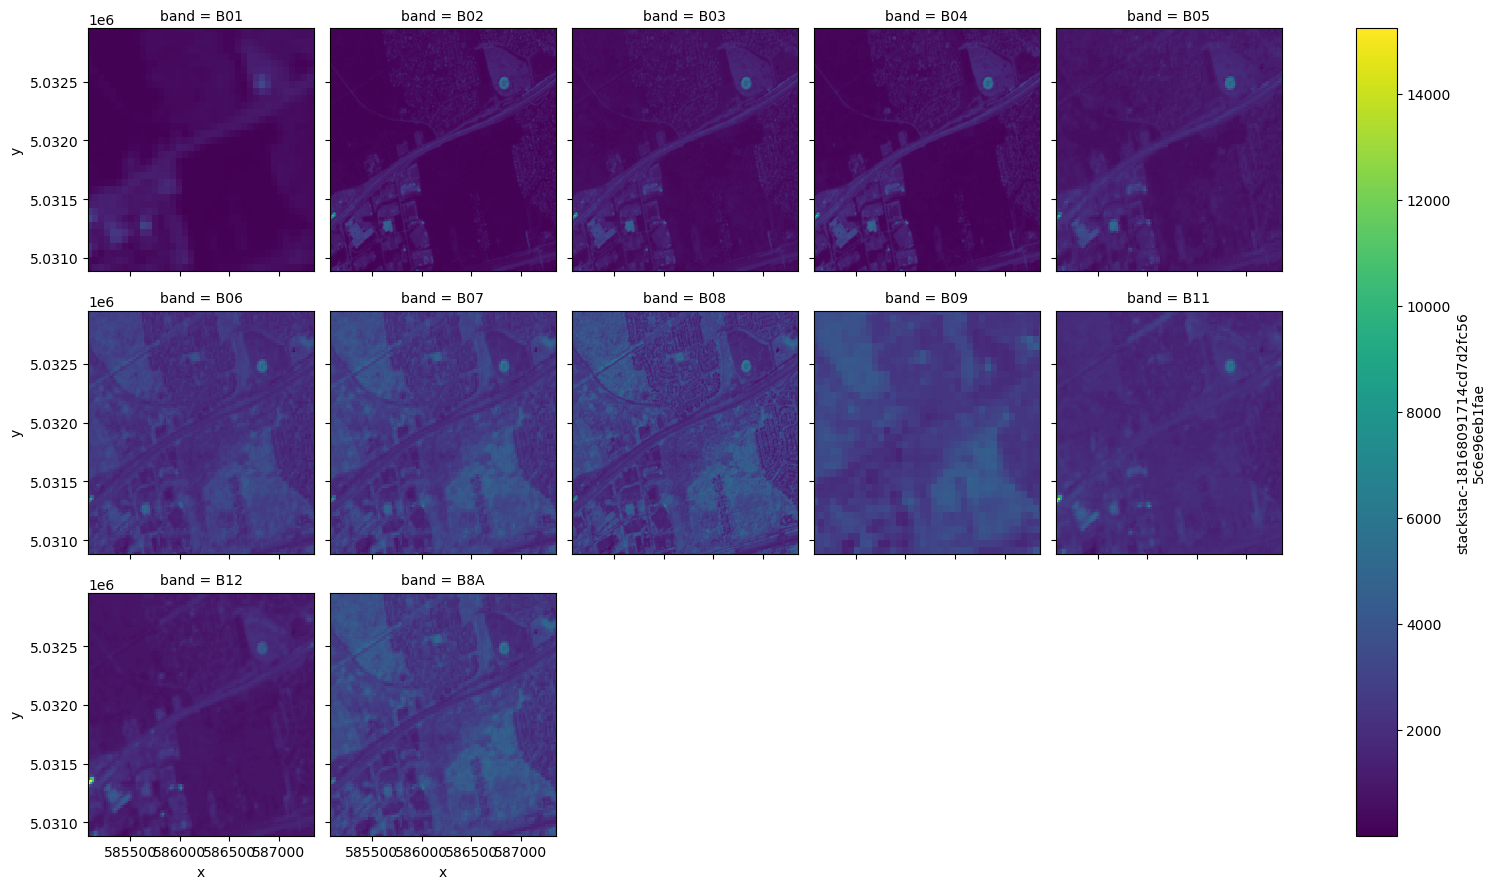

In [14]:
# Visualize each band
data[0].plot.imshow(x='x', y='y', col='band', col_wrap=5)

We are going to normalize our data and shift it into a int8 [0, 255] scale. 

In [15]:
def normalize(array):
    norm = ((array - array.min()) / (array.max() - array.min())*255).astype(np.int8)
    return norm

In [16]:
data_norm = normalize(data)
data_norm

<xarray.DataArray 'stackstac-18168091714cd7d2fc565c6e96eb1fae' (time: 1,
                                                                band: 12,
                                                                y: 207, x: 228)>
dask.array<astype, shape=(1, 12, 207, 228), dtype=int8, chunksize=(1, 1, 207, 228), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2021-08-03...
    id                                       (time) <U54 'S2A_MSIL2A_20210803...
  * band                                     (band) <U3 'B01' 'B02' ... 'B8A'
  * x                                        (x) float64 5.851e+05 ... 5.874e+05
  * y                                        (y) float64 5.033e+06 ... 5.031e+06
    sat:relative_orbit                       int64 54
    ...                                       ...
    title                                    (band) <U37 'Band 1 - Coastal ae...
    gsd                                      (band) float64 60.0 10.0 ... 20.0
    common_name                              (band) object 'coastal' ... 'red...
    center_wavelength                        (band) float64 0.443 0.49 ... 0.865
    full_width_half_max                      (band) float64 0.027 ... 0.033
    epsg                                     int64 32618

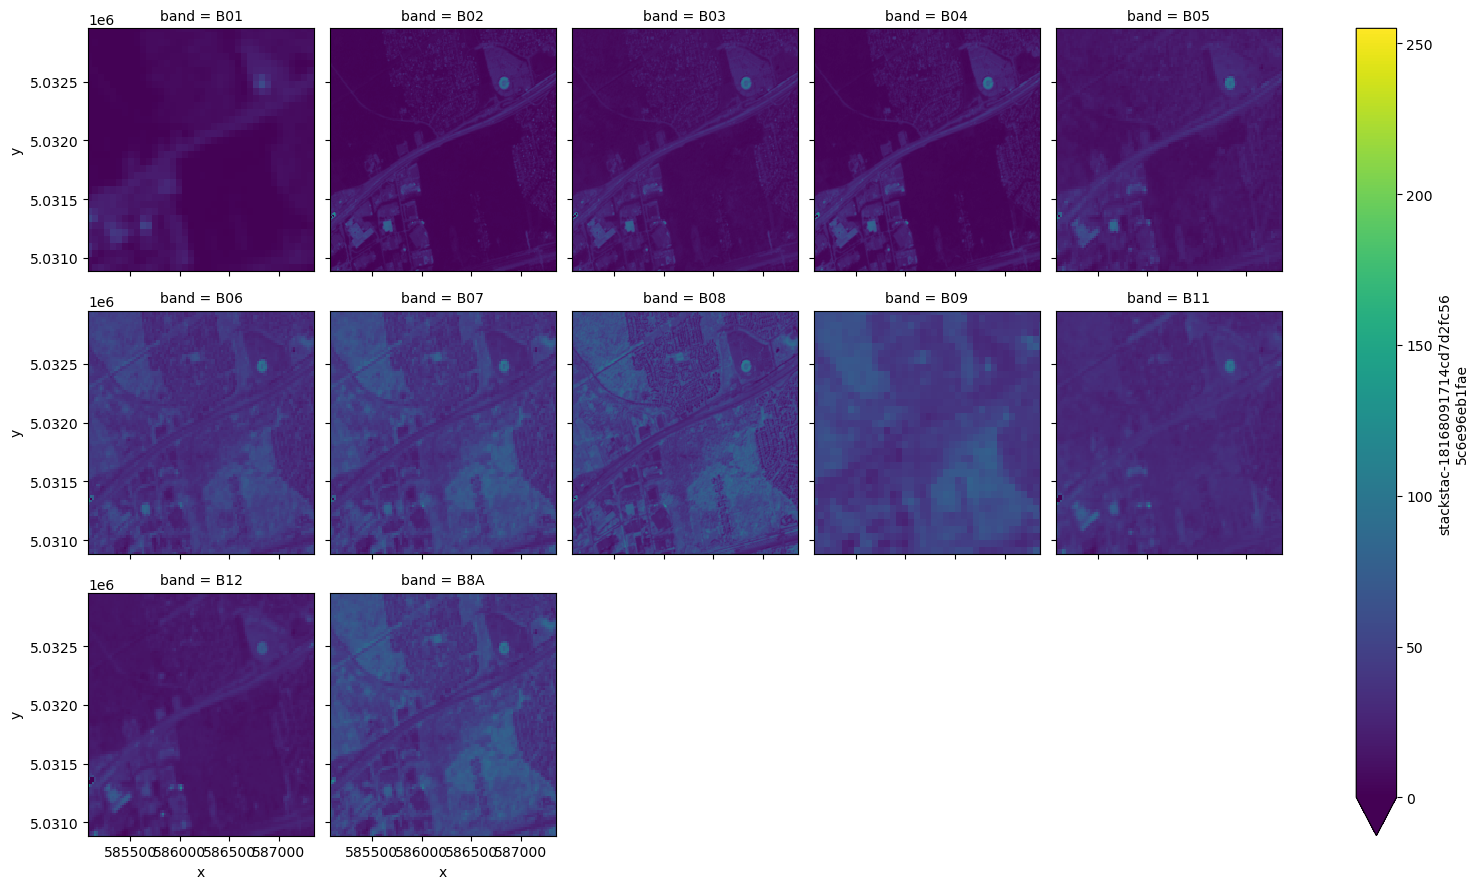

In [17]:
# Visualize the normalized data and see that it's visually the same as before
data_norm[0].plot.imshow(x='x', y='y', col='band', col_wrap=5, vmin=0, vmax=255)

## Initialize K-Means Algorithm

In [18]:
km = dask_ml.cluster.KMeans(n_clusters=4, oversampling_factor=0)
km

KMeans(n_clusters=4, oversampling_factor=0)

## Data Preprocessing

Start by figuring out the shape of our data. Doing so will give us a better understanding of how to manipulate the data for the algorithm.

In [19]:
arr_shape = data.shape
arr_shape

(1, 12, 207, 228)

The K-Means algorithm requires a 2-dimensional array as an input. First we will essentially flatten the bands invidiually and then we will transpose the array so that each "column" represents a band. 

In [20]:
arr = data_norm.data[0].reshape(arr_shape[1], arr_shape[2]*arr_shape[3]).T
arr

dask.array<transpose, shape=(47196, 12), dtype=int8, chunksize=(47196, 1), chunktype=numpy.ndarray>

Make sure the entire array is visible to the K-Means algorithm (not as chunks - you will get Errors)

In [21]:
arr_rc = arr.rechunk({1: arr.shape[1]})
arr_rc

dask.array<rechunk-merge, shape=(47196, 12), dtype=int8, chunksize=(47196, 12), chunktype=numpy.ndarray>

## Fitting The K-Means Algorithm

Here we will fit our input AOI imagery in to the K-Means algorithm

In [22]:
%%time
km.fit(arr_rc)

Found fewer than 4 clusters in init (found 1).


CPU times: user 2.58 s, sys: 65.4 ms, total: 2.64 s
Wall time: 24.9 s


KMeans(n_clusters=4, oversampling_factor=0)

## Predicting Our Classification Clusters

Once fitted, we can then perform predictions based on the calculated centroids of the input AOI imagery. For simplicity, we are using the same input for both fitting and prediction. Some fitted algorithms can be extended to similar areas - too dissimilar then the results will not be confident. 

In [23]:
%%time
pred = km.predict(arr_rc)
pred

CPU times: user 34.8 ms, sys: 250 µs, total: 35.1 ms
Wall time: 228 ms


dask.array<astype, shape=(47196,), dtype=int32, chunksize=(47196,), chunktype=numpy.ndarray>

To visualize the data, we will need to reverse the steps we performed to the input. So, we will transpose and then reshape back into the original X and Y dimensions. 

In [24]:
pred = pred.T.reshape(arr_shape[2], arr_shape[3])
pred

dask.array<reshape, shape=(207, 228), dtype=int32, chunksize=(207, 228), chunktype=numpy.ndarray>

Below is an RGB (left) and K-Means Cluster Prediction segmenation map (right) of our input AOI

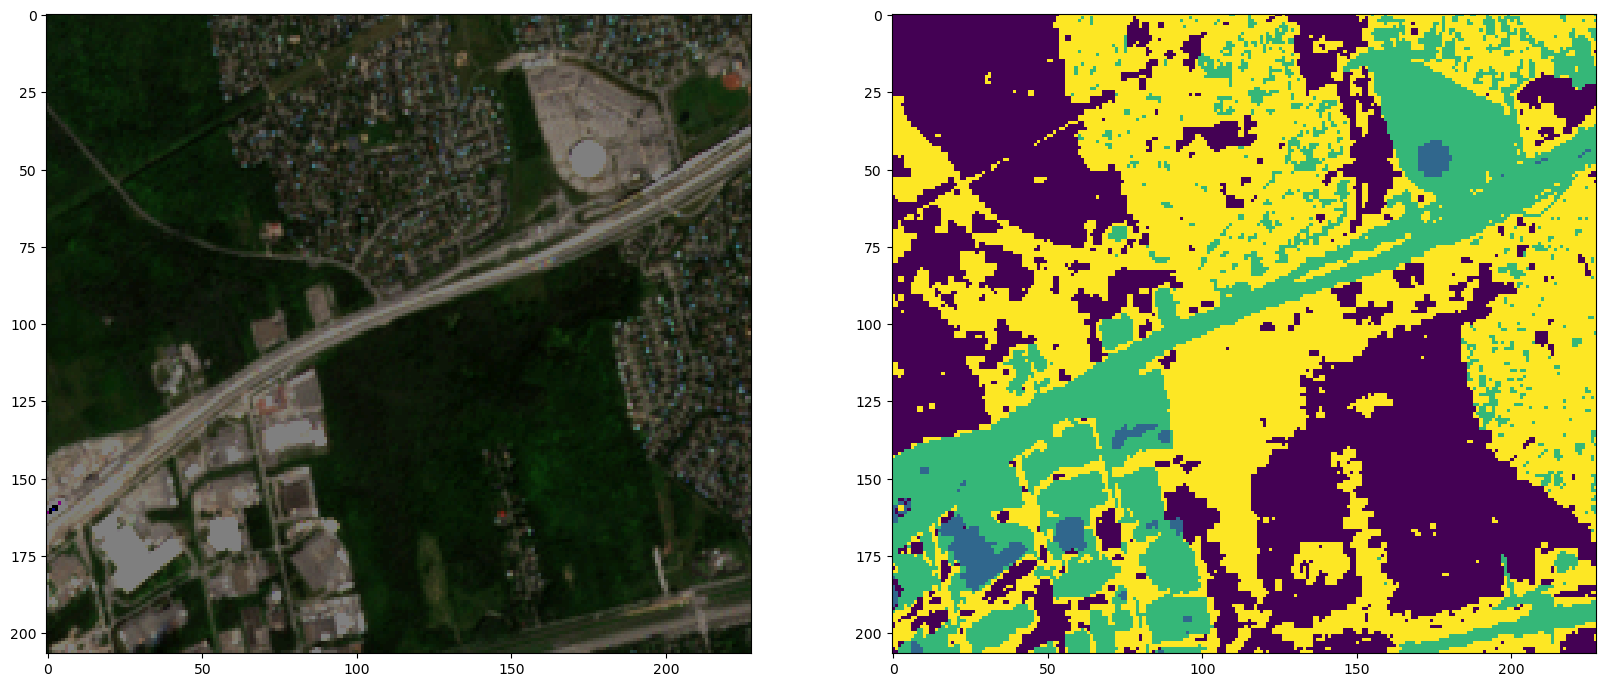

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(rescale_intensity(data_norm[0].sel(band=['B04','B03','B02']).data, in_range=(0,30)).transpose(1,2,0))
ax[1].imshow(pred)

As you can see, the K-Means can easily pick out major concrete infrastructure such as industry areas and highways. It also appears to do a decent job at separating different vegetation densities/types. However, in the residential/urban areas the algorithm doesn't do as well. That could be an element of the sensor's spatial resolution and the quality of the segmentation map could be improved on by adding more indicies (eg: NDVI) to the input/prediction operations. 

In [ ]:
cluster.shutdown()